<a href="https://colab.research.google.com/github/xjseabrum/nndl_final_project/blob/main/FinalProject_NNDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Import Statements

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os as os
os.chdir("/content/gdrive/MyDrive/NNDL Final Project")

In [ ]:
!pip3 install -r requirements.txt

     |████████████████████████████████| 256 kB 5.1 MB/s 


In [ ]:
import json
import math
import pandas as pd
import datetime
import h5py
# Using the TweetTokenizer as Twitch chat is spammy and is not formal.
# Also catches text emojis like :) , <3 , and D:
from nltk.tokenize import TweetTokenizer
import pickle5 as pickle
from gensim.models import Word2Vec
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from keras.layers import GRU
from keras.layers import TextVectorization
from keras.layers import Embedding
from keras.initializers import Constant
from keras import layers, Input, Model
import matplotlib.pyplot as plt

# Helper Functions and Class Declarations

## Helper Functions

In [ ]:
# For making sure all the words in the
# list are lowercase before performing training with w2v
def lowercase_words(sentence_list):
    sent_list = list(sentence_list)
    sents = []
    sentences = range(len(sent_list))
    for sent in sentences:
        row = sentence_list[sent]
        # Removing empty string characters as they're... empty.
        lowercase = [x.lower() if x != "\U000e0000" else "" for x in row]
        while ("" in lowercase):
            lowercase.remove("")
        sents.append(lowercase)
    return sents

In [ ]:
# For manually setting the labels for values
def set_labels(value):
    if value < 0 :
        return "negative"
    if value > 0:
        return "positive"
    return "neutral"

In [ ]:
# For saving an object to file provided that that filename
# doesn't already exist
def save_to_file(filename, item):
    if os.path.exists(filename):
        print(f"{filename} already exists in the path.  WILL NOT OVERWRITE!")
    else:
        print(f"Saving {filename} to the path...")
        with open(filename, 'wb') as f:
            pickle.dump(item, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Saved {filename}!")

In [ ]:
# For loading in a pickled file
def load_pickle_file(filename):
    return pickle.load(open(filename, "rb"))

In [ ]:
# For implementing checkpointing
def set_up_checkpoint(checkpoint_name):
  return ModelCheckpoint(checkpoint_name, 
                         monitor = "val_acc",
                         mode = 'max',
                         save_best_only = True,
                         save_weights_only = True, 
                         verbose = 1)

In [ ]:
# For providing the argmax class amongst the predictions
def output_prediction(prediction_list):
    predictions = []
    rows = range(len(prediction_list))
    for row in rows:
        query = prediction_list[row]
        arg_max_idx = np.argmax(query)
        predictions.append(arg_max_idx)
    return np.array(predictions)

In [ ]:
# For printing out the prec-recall-f1 scores and accuracy
def output_prediction_results(pred_list, name_list, test_vec):
    assert isinstance(pred_list, list), "The pred_list should be a list."
    assert isinstance(name_list, list), "The name_list should be a list."
    assert (len(pred_list) == len(name_list)), "The length of the two lists is not the same."
    for item in range(len(pred_list)):
        print("="*65)
        print(name_list[item] + " results:\n")
        print(metrics.classification_report(test_vec, pred_list[item], digits = 3))
        print("\nConfusion Matrix:")
        conf_mat = confusion_matrix(test_vec, pred_list[item])
        conf_mat_perc = confusion_matrix(test_vec, pred_list[item], 
                                         normalize = 'true')
        print(conf_mat)
        disp_cnt = ConfusionMatrixDisplay(confusion_matrix = conf_mat)
        disp_cnt.plot()
        disp_cnt.ax_.set_title(f"{name_list[item]} Count Conf. Mat.")
        disp_per = ConfusionMatrixDisplay(confusion_matrix = conf_mat_perc)
        disp_per.plot()
        disp_per.ax_.set_title(f"{name_list[item]} Row (True) Percent Conf. Mat.")

## Classes

In [ ]:
# This class takes in a json filepath
# and outputs a pandas dataframe if 
# get_pandas(json_filepath) is called

# message.is_action seems to capture when a user does a ! command in chat
# useful to use as a filter for subsetting.

# message.user_notice_params.msg-id captures when a user subscribes or when 
# a user uses a bits badge tier notification. Useful for subsetting

# The subset cutoffs in __subset_frame
# are based on looking at the .describe() stats of
# the chats and taking the average across them.  
# Also, we know we want chats that contain
# at least 3 tokens anyway for embedding purposes.
# Chats over 20 tokens are likely mega-spam or bot messages
# such as X subscribed for Y-months etc.
# The subset isn't perfect, but should get at the core of it all.

class PreProcessTwitchJSON:
    def __init__(self):
        self.pandas_output = None
        self.suppress = False
        self.encoder = 'utf-8'
        self.tokenizer = TweetTokenizer()
        self.json_filepath = None
        self.filename = None
        self.min_token = 3
        self.max_token = 20
        self.min_ratio = 0.65
        #Do we want to keep some of these columns as features in our model>
        #maybe time has some influence
        self.drop_columns = ["_id", "created_at", "updated_at", "content_type", 
                             "content_id", "source", "state", "more_replies", 
                             "commenter.display_name", "commenter._id", 
                             "commenter.bio", "commenter.created_at", 
                             "commenter.updated_at", "commenter.logo", 
                             "message.bits_spent", "message.user_badges", 
                             "message.user_color"]
    
    def __read_json_output_df(self):
        with open(self.json_filepath, 'r', encoding = self.encoder) as f:
            json_data = json.loads(f.read())
        output_data = pd.json_normalize(json_data, record_path = ['comments'])
        self.pandas_output = output_data
    
    def __create_timestamp(self):
        stamp = [str(datetime.timedelta(seconds = math.floor(x))) for x in 
                 self.pandas_output.content_offset_seconds]
        self.pandas_output["stream_timestamp"] = stamp
    
    def __chat_tokenize(self):
        chat_iterator = iter(self.pandas_output["message.body"])
        tokens = []
        token_length = []
        unique_tokens = []
        unique_length = []
        for chat in chat_iterator:
            tokenized_chat = self.tokenizer.tokenize(chat)
            tokens.append(tokenized_chat)
            token_length.append(len(tokenized_chat))
            unique_tokens.append(list(set(tokenized_chat)))
            unique_length.append(len(set(tokenized_chat)))
        self.pandas_output["chat_tokens"] = tokens
        self.pandas_output["chat_length"] = token_length
        self.pandas_output["unique_tokens"] = unique_tokens
        self.pandas_output["unique_length"] = unique_length
        self.pandas_output["unique_ratio"] = self.pandas_output["unique_length"] / self.pandas_output["chat_length"]
    
    def __set_filepath(self, filepath):
        self.json_filepath = filepath
    
    def __clean_columns(self):
        self.pandas_output = self.pandas_output.drop(columns = self.drop_columns)
    
    def __subset_frame(self):
        self.pandas_output = self.pandas_output[(self.pandas_output["chat_length"] >= self.min_token) & 
                                                (self.pandas_output["unique_ratio"] >= self.min_ratio) & 
                                                (self.pandas_output["chat_length"] <= self.max_token) &
                                                (self.pandas_output["message.is_action"] == False) & 
                                                (self.pandas_output["message.user_notice_params.msg-id"].isna())]
        self.pandas_output = self.pandas_output.drop(columns = ["message.is_action",
                                                                "message.user_notice_params.msg-id"])

    def __get_info(self):
        if not self.suppress:
            print("="*65)
            print("Dataframe information:\n" + "="*65)
            self.pandas_output.info()
        print("="*65)
        print("{} chat(s) processed from the {} JSON file.".format(
                                       len(self.pandas_output), self.filename))
        print("="*65)
    
    def get_pandas(self, json_filepath, suppress = True, subset = False):
        self.suppress = suppress
        self.filename = json_filepath.split(".")[0]
        self.__set_filepath(json_filepath)
        self.__read_json_output_df()
        self.__create_timestamp()
        self.__chat_tokenize()
        self.__clean_columns()
        if subset == True:
            self.__subset_frame()
        self.__get_info()
        return self.pandas_output

# Preprocess the Twitch JSON Data

In [ ]:
# Create the class object
preproc = PreProcessTwitchJSON()

In [ ]:
# Bring in the data from different streamers
xqc = preproc.get_pandas("chatlogs/xQcOW.json")
mizkif = preproc.get_pandas("chatlogs/Mizkif.json")
emiru = preproc.get_pandas("chatlogs/Emiru.json")
fuslie = preproc.get_pandas("chatlogs/fuslie.json")
sykkuno = preproc.get_pandas("chatlogs/Sykkuno.json")
qt = preproc.get_pandas("chatlogs/QTCinderella.json")

332740 chat(s) processed in the chatlogs/xQcOW JSON file.
269699 chat(s) processed in the chatlogs/Mizkif JSON file.
114954 chat(s) processed in the chatlogs/Emiru JSON file.
67945 chat(s) processed in the chatlogs/fuslie JSON file.
39664 chat(s) processed in the chatlogs/QTCinderella JSON file.
61239 chat(s) processed in the chatlogs/Sykkuno JSON file.


In [ ]:
xqc2 = preproc.get_pandas("chatlogs/xQcOW.json", subset = True)
mizkif2 = preproc.get_pandas("chatlogs/Mizkif.json", subset = True)
emiru2 = preproc.get_pandas("chatlogs/Emiru.json", subset = True)
fuslie2 = preproc.get_pandas("chatlogs/fuslie.json", subset = True)
sykkuno2 = preproc.get_pandas("chatlogs/Sykkuno.json", subset = True)
qt2 = preproc.get_pandas("chatlogs/QTCinderella.json", subset = True)

93959 chat(s) processed from the chatlogs/xQcOW JSON file.
70324 chat(s) processed from the chatlogs/Mizkif JSON file.
24603 chat(s) processed from the chatlogs/Emiru JSON file.
21645 chat(s) processed from the chatlogs/fuslie JSON file.
19147 chat(s) processed from the chatlogs/Sykkuno JSON file.
14702 chat(s) processed from the chatlogs/QTCinderella JSON file.


In [ ]:
# Pickle the subset dataframes
xqc2.to_pickle("xqc_subset.pkl")
mizkif2.to_pickle("mizkif_subset.pkl")
emiru2.to_pickle("emiru_subset.pkl")
fuslie2.to_pickle("fuslie_subset.pkl")
sykkuno2.to_pickle("sykkuno_subset.pkl")
qt2.to_pickle("qt_subset.pkl")

In [ ]:
# Conjoin the dataframes
conjoined = pd.concat([xqc2, mizkif2, emiru2, fuslie2, sykkuno2, qt2], 
                      ignore_index = True)
conjoined

,channel_id,content_offset_seconds,commenter.name,commenter.type,message.body,message.fragments,message.emoticons,stream_timestamp,chat_tokens,chat_length,unique_tokens,unique_length,unique_ratio
0,71092938,11.687,steeltalonsx,user,told u guys,"[{'text': 'told u guys', 'emoticon': None}]",None,0:00:11,"[told, u, guys]",3,"[u, told, guys]",3,1.000000
1,71092938,11.863,appleairpod,user,PagMan 󠀀󠀀,"[{'text': 'PagMan 󠀀󠀀', 'emoticon': None}]",None,0:00:11,"[PagMan, 󠀀, 󠀀]",3,"[PagMan, 󠀀]",2,0.666667
2,71092938,12.436,skubru,user,actually live PogU,"[{'text': 'actually live PogU', 'emoticon': No...",None,0:00:12,"[actually, live, PogU]",3,"[PogU, actually, live]",3,1.000000
3,71092938,12.636,xl_sxca_lx,user,wtdf is happening,"[{'text': 'wtdf is happening', 'emoticon': None}]",None,0:00:12,"[wtdf, is, happening]",3,"[wtdf, happening, is]",3,1.000000
4,71092938,15.645,bhobrain,user,POG U LIVER,"[{'text': 'POG U LIVER', 'emoticon': None}]",None,0:00:15,"[POG, U, LIVER]",3,"[LIVER, U, POG]",3,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244375,247808909,24064.357,shaynanegins,user,ty for the strim!,"[{'text': 'ty for the strim!', 'emoticon': None}]",None,6:41:04,"[ty, for, the, strim, !]",5,"[for, the, ty, strim, !]",5,1.000000
244376,247808909,24064.381,cj_dr20,user,good stream qtcLove,"[{'text': 'good stream ', 'emoticon': None}, {...","[{'_id': '302080676', 'begin': 12, 'end': 18}]",6:41:04,"[good, stream, qtcLove]",3,"[qtcLove, good, stream]",3,1.000000
244377,247808909,24065.024,mowmoogly,user,bye everyone peepoBye,"[{'text': 'bye everyone peepoBye', 'emoticon':...",None,6:41:05,"[bye, everyone, peepoBye]",3,"[peepoBye, bye, everyone]",3,1.000000
244378,247808909,24078.463,ahmedaces,user,why is peepoBye bttv and 7tv,"[{'text': 'why is peepoBye bttv and 7tv', 'emo...",None,6:41:18,"[why, is, peepoBye, bttv, and, 7tv]",6,"[7tv, and, peepoBye, why, bttv, is]",6,1.000000


In [ ]:
# Save the conjoined frame
if os.path.exists("conjoined_subset.pkl") == False:
    conjoined.to_pickle("conjoined_subset.pkl")

# Load in the pre-saved Twitch dataframe

In [ ]:
# Load in the conjoined dataset
conjoined = pd.read_pickle("conjoined_subset.pkl")

# Word2Vec embeddings

In [ ]:
sentences =  conjoined.loc[:,"chat_tokens"]
sents = lowercase_words(sentences)

In [ ]:
len(sents)

244380

In [ ]:
sentences[0:10]

0           [told, u, guys]
1            [PagMan, 󠀀, 󠀀]
2    [actually, live, PogU]
3     [wtdf, is, happening]
4           [POG, U, LIVER]
5          [pog, you, live]
6           [PogU, REAL, 󠀀]
7           [MR, COW, PogU]
8      [PogU, not, retired]
9           [PogU, REAL, 󠀀]
Name: chat_tokens, dtype: object

In [ ]:
# Loading in the extra embeddings
# these were generated with the "ExtraTwitchMessages.py"
# code in the folder.
# Takes 14s to load in
extra_messages = load_pickle_file("extra_twitch_messages.pkl")

In [ ]:
len(extra_messages)

5841389

In [ ]:
sents_extra = sents + extra_messages

In [ ]:
sentarr = np.array(sents, dtype = "object")
sentarr_extra = np.array(sents_extra, dtype = "object")

In [ ]:
# train model
w2v_embeddings = Word2Vec(sentarr, min_count = 6, size = 200)

# twitch embeddings take roughly 3 min to train additionally
# because the twitch_embeddings corpus is so large
# we can be more aggresive with the min_count value
twitch_embeddings = Word2Vec(sentarr_extra, min_count = 15, size = 200)

# summarize the loaded models
print(w2v_embeddings)
print(twitch_embeddings)

Word2Vec(vocab=9524, size=200, alpha=0.025)
Word2Vec(vocab=54451, size=200, alpha=0.025)


In [ ]:
w2v_embeddings.wv.most_similar(positive="lol", topn = 20)

[('lmao', 0.909743070602417),
 ('kekw', 0.8178013563156128),
 ('literally', 0.7755635380744934),
 ('probably', 0.7564040422439575),
 ('yep', 0.7445864677429199),
 ('because', 0.7294270992279053),
 ('most', 0.7215163111686707),
 ('by', 0.7148621082305908),
 ('lulw', 0.7088608145713806),
 ('tho', 0.6857784390449524),
 ('cause', 0.6663498878479004),
 ('bc', 0.6599993705749512),
 ('though', 0.6574540138244629),
 ('failfish', 0.6570232510566711),
 ('even', 0.6426588296890259),
 ('without', 0.638812780380249),
 ('also', 0.635379433631897),
 ('when', 0.6306459307670593),
 ('from', 0.6285984516143799),
 ('and', 0.6260555386543274)]

In [ ]:
twitch_embeddings.wv.most_similar(positive="lol", topn = 20)

[('lmao', 0.8908963799476624),
 ('lul', 0.7165015339851379),
 ('lmfao', 0.6708642244338989),
 ('lulw', 0.6602413654327393),
 ('haha', 0.6508798599243164),
 ('xd', 0.6468310356140137),
 ('but', 0.6133180260658264),
 ('and', 0.6004449725151062),
 ('rofl', 0.5744327306747437),
 ('hahaha', 0.5576643943786621),
 ('tho', 0.5313534736633301),
 ('though', 0.5209619998931885),
 ('kappa', 0.5193719863891602),
 ('that', 0.5108391642570496),
 ('kekw', 0.5047675967216492),
 ('because', 0.4990473985671997),
 ('literally', 0.4965772032737732),
 ('just', 0.49364522099494934),
 ('cause', 0.4897365868091583),
 ('lolol', 0.48933732509613037)]

# Glove Embeddings, 200D

In [ ]:
# Load in the embedding file
path_to_glove_file = "glove.6B.200d.txt"
glove_embeddings = {}
i = 0
with open(path_to_glove_file) as f:
    for line in f:
        # if i < 10:
        #   print(line)
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs
        i += 1
print(f"{i} word(s) loaded in.")
del(i)

400000 word(s) loaded in.


In [ ]:
print(glove_embeddings["hello"])

[ 0.26609    0.21821   -0.10996   -0.48408   -0.11181   -0.09882
 -0.45315    0.44198   -0.034614   0.10541   -0.29537   -0.10881
  0.20916    0.52484   -0.17985   -0.31187   -0.25724    0.65267
  0.217      0.86503    0.47239   -0.078582   0.31035   -0.12155
 -0.12502   -0.40418    0.53803   -0.57842   -0.63668   -0.13502
 -0.040484   0.41378   -0.63201   -0.38847   -0.43767   -0.19706
  0.2878     0.36039   -0.032893  -0.20361   -0.34918    0.95923
 -0.51221   -0.19035    0.1567     0.17704    0.55302    0.27636
 -0.13707    0.91361    0.25948   -0.30107    0.48343   -0.046869
 -0.2796    -0.040385  -0.45773    0.2768    -0.14468    0.036539
  0.36018   -0.54939    0.19359   -0.38263   -0.29661   -0.18938
  0.095681   0.46646    0.3366     0.78351    0.49517   -0.82418
  0.34402   -0.50038   -0.71074   -0.25711   -0.36619    0.61746
 -0.31281   -0.042413   0.37915   -0.62383    0.27208    0.32852
 -0.23045   -0.12469    0.29898   -0.22525   -0.27045   -0.4447
 -0.15889    0.20325   -

In [ ]:
print(w2v_embeddings["hello"])

[ 0.01211837  0.17919388  0.31367493 -0.671889    0.6610753  -0.9802314
  0.13803974 -0.3237668  -0.49687505 -0.05531858 -1.0474763  -0.4973724
 -0.0770257   0.1710688   0.05304653  0.05185505 -0.29615745  0.35784164
  0.28335634  0.04160067  0.23523903  0.6186477  -0.3207673  -0.3991383
 -0.06581183  0.18779753 -0.32003504  0.49727604  0.21201622 -0.27140218
 -0.2943641  -0.1704792   0.35214567 -0.00413887 -0.51407874 -0.37616068
  0.28061345 -0.47092682  0.06005165 -0.27100176 -0.33557677  0.259495
 -0.14353018 -0.38106045 -0.29738572  0.21828735  0.4742148   0.34103653
 -0.3015406  -0.34970233 -0.14618272  0.35857007  0.88258475 -0.20470941
 -0.12177773  0.27092424 -0.07992647 -0.400799   -0.3885138   0.3444816
 -0.50173324  0.1897213  -0.5696292   0.23238267  0.56637406 -0.20859882
  0.92135483 -0.10089317  0.53516704 -0.04694844 -0.5505627   0.01426697
  0.06851386 -0.34258226 -0.18158025 -0.5579824  -0.3587582   0.47229952
 -0.60410315  0.31920528 -0.6593409  -0.28800178  0.33279

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


# Bring in the Kobs dataset

In [ ]:
df = pd.read_csv("labeled_dataset.csv")

In [ ]:
df

,sentiment,date,channel,game,user,mod,subscriber,message
0,1,2018-05-22T21:10:33.896Z,forsen,Burnout Paradise,63102,False,True,OMEGALUL
1,1,2018-05-14T19:44:26.871Z,forsen,Super Mario Odyssey,87065,False,True,pepeL Clap pepeL Clap pepeL Clap pepeL Clap pe...
2,1,2018-05-10T17:33:24.377Z,forsen,Darwin Project,2291,False,True,🏹 ZULUL
3,-1,2018-05-28T20:18:47.903Z,sodapoppin,SpeedRunners,754606,False,False,Cata dumbass
4,0,2018-05-15T23:46:45.381Z,sodapoppin,ROBLOX,10535368,False,False,D:
...,...,...,...,...,...,...,...,...
1917,1,2018-05-26T06:15:54.306Z,moonmoon_ow,Dark Souls,330564,False,False,EZ farm
1918,0,2018-05-03T02:31:55.727Z,sodapoppin,Ori and the Blind Forest,969908,False,True,@Cent D:
1919,0,2018-05-03T17:25:58.561Z,forsen,Shoppe Keep 2,769957,False,False,!roulette all
1920,0,2018-05-29T18:20:28.632Z,forsen,Dark Souls,825208,False,True,ANELE


In [ ]:
# Lowercase the message in the dataframe:
df["message"] = df["message"].apply(lambda x: x.lower())

In [ ]:
X = df.loc[:, df.columns != "sentiment"]
Y = df.loc[:, df.columns == "sentiment"]

In [ ]:
from collections import Counter

In [ ]:
counter = Counter(Y["sentiment"].to_list())

In [ ]:
len(x_test)

385

In [ ]:
193print(f"{770/len(Y)}   {748/len(Y)}   {404/len(Y)}")

0.4006243496357961   0.3891779396462019   0.21019771071800208


In [ ]:
counter.Counter(Y["sentiment"].to_list())

AttributeError: ignored

In [ ]:
Y["sentiment"] = Y["sentiment"].apply(lambda val: set_labels(val))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Load in the index data if they already exist
loaded_train_idx = load_pickle_file("train_df_idx_05_05_2022.pkl")
loaded_valid_idx = load_pickle_file("valid_df_idx_05_05_2022.pkl")
loaded_test_idx = load_pickle_file("test_df_idx_05_05_2022.pkl")

In [ ]:
x_train = X.loc[loaded_train_idx, :]
x_valid = X.loc[loaded_valid_idx, :]
x_test = X.loc[loaded_test_idx, :]

y_train = Y.loc[loaded_train_idx, :]
y_valid = Y.loc[loaded_valid_idx, :]
y_test = Y.loc[loaded_test_idx, :]

In [ ]:
# Create a stratified train/valid/test split (80/10/10).
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    stratify = Y, 
                                                    test_size = 0.2, 
                                                    random_state = 2022)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train,
                                                    stratify = y_train, 
                                                    test_size = 193/1537, 
                                                    random_state = 2022)

In [ ]:
print(f"{len(x_train)/len(df)}  {len(x_valid)/len(df)}  {len(x_test)/len(df)}")

0.6992715920915713  0.1004162330905307  0.20031217481789804


In [ ]:
train_idx = x_train.index.values
valid_idx = x_valid.index.values
test_idx = x_test.index.values

In [ ]:
# Saving these to file:
save_to_file(filename = "train_df_idx_05_05_2022.pkl", item = train_idx)
save_to_file(filename = "valid_df_idx_05_05_2022.pkl", item = valid_idx)
save_to_file(filename = "test_df_idx_05_05_2022.pkl", item = test_idx)

train_df_idx_05_05_2022.pkl already exists in the path.  WILL NOT OVERWRITE!
valid_df_idx_05_05_2022.pkl already exists in the path.  WILL NOT OVERWRITE!
test_df_idx_05_05_2022.pkl already exists in the path.  WILL NOT OVERWRITE!


In [ ]:
# Useful columns to consider in the dataframe
COLUMNS = ["channel", "mod", "subscriber"]

In [ ]:
# Defining the class to index relation
classes = ['negative', 'neutral', 'positive']
class_to_index = {'negative': 0, 'neutral': 1, 'positive': 2}
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
# Make everything a list
train_message = [x for x in x_train["message"]]
valid_message = [x for x in x_valid["message"]]
test_message = [x for x in x_test["message"]]

train_metadata = x_train[COLUMNS] 
valid_metadata = x_valid[COLUMNS]
test_metadata = x_test[COLUMNS]

train_labels = np.array(names_to_ids(y_train["sentiment"].to_list()))
valid_labels = np.array(names_to_ids(y_valid["sentiment"].to_list()))
test_labels = np.array(names_to_ids(y_test["sentiment"].to_list()))

In [ ]:
MAX_TOKENS = int(math.pow(2, 14)) #16384
# Max Twitch message can be is 500 characters.
# Words typically are around 5 characters on average
# But because twitch has emotes that are kind of long, let's
# assume an average of 7 characters per word
# That means, at most, the output sequence should be is 71.5
# so setting the sequence length to 75
OUTPUT_SEQUENCE_LENGTH = 75
BATCH_SIZE = int(math.pow(2, 7)) #128

In [ ]:
# Set up the vectorizer
vectorizer = TextVectorization(max_tokens = MAX_TOKENS, 
                               output_sequence_length = OUTPUT_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(train_message).batch(BATCH_SIZE)
vectorizer.adapt(text_ds)
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
x_train_message_vec = vectorizer(np.array([[s] for s in train_message])).numpy()
x_valid_message_vec = vectorizer(np.array([[s] for s in valid_message])).numpy()
x_test_message_vec = vectorizer(np.array([[s] for s in test_message])).numpy()

y_train_vec = train_labels
y_valid_vec = valid_labels
y_test_vec = test_labels

#Finalize the Embeddings for the Models

In [ ]:
# Construct a staggered embedding structure
# sample first from the w2v vectors
# then sample from the glove vectors
# and if that fails make an array of [0] * embedding_dimension

EMBEDDING_DIMENSION = 200
NUM_TOKENS = len(voc)

embedding_matrix = np.zeros((NUM_TOKENS, EMBEDDING_DIMENSION))

# Create the embedding matrix
# Check first to see if the word exists in the w2v (Twitch) embedding scheme
# if not, then check the glove embedding
# if not, then that word's embedding will be set to [0]*EMBEDDING_DIMENSION

hits = 0
misses = 0
for word, idx in word_index.items():
    if word in w2v_embeddings:
        embedding_vector = w2v_embeddings[word]
        hits += 1
    elif word in glove_embeddings:
        embedding_vector = glove_embeddings[word]
        hits += 1
    else:
        embedding_vector = None
        misses += 1
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector 

print(f"Converted {hits} word(s) with {misses} miss(es): " + 
      f"{round(100*misses/(hits+misses),1)}% miss rate.\n\n")      

Converted 1565 word(s) with 523 miss(es): 25.0% miss rate.




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
# Construct a staggered embedding structure
# sample first from the w2v vectors
# then sample from the glove vectors
# and if that fails make an array of [0] * embedding_dimension

EMBEDDING_DIMENSION = 200
NUM_TOKENS = len(voc)

twitch_embedding_matrix = np.zeros((NUM_TOKENS, EMBEDDING_DIMENSION))

# Create the embedding matrix WITH THE EXTENDED EMBEDDING
# Check first to see if the word exists in the w2v (Twitch) embedding scheme
# if not, then check the glove embedding
# if not, then that word's embedding will be set to [0]*EMBEDDING_DIMENSION

hits = 0
misses = 0
for word, idx in word_index.items():
    if word in twitch_embeddings:
        embedding_vector = twitch_embeddings[word]
        hits += 1
    elif word in glove_embeddings:
        embedding_vector = glove_embeddings[word]
        hits += 1
    else:
        embedding_vector = None
        misses += 1
    if embedding_vector is not None:
        twitch_embedding_matrix[idx] = embedding_vector 

print(f"Converted {hits} word(s) with {misses} miss(es): " + 
      f"{round(100*misses/(hits+misses),1)}% miss rate.\n\n")

Converted 1694 word(s) with 394 miss(es): 18.9% miss rate.




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
zero_matrix = np.zeros((NUM_TOKENS, EMBEDDING_DIMENSION))

# Saving the finalized embeddings to file

In [ ]:
# Save embeddings to file after alternating between choosing
# the w2v trained twitch embeddings and the usual glove ones
save_to_file(filename = "basic_embeddings_05_05_2022.pkl", item = embedding_matrix)

Saving basic_embeddings_05_05_2022.pkl to the path...
Saved basic_embeddings_05_05_2022.pkl!


In [ ]:
save_to_file(filename = "extended_embeddings_05_05_2022.pkl", 
             item = twitch_embedding_matrix)

Saving extended_embeddings_05_05_2022.pkl to the path...
Saved extended_embeddings_05_05_2022.pkl!


In [ ]:
# Load in the embeddings, if they already exist
# Short embeddings:
embedding_matrix = load_pickle_file("basic_embeddings_05_05_2022.pkl")
# Long Embeddings
twitch_embedding_matrix = load_pickle_file("extended_embeddings_05_05_2022.pkl")

# Model Building

In [ ]:
# Hyperparameters
OBJECTIVE_FUNC = "sparse_categorical_crossentropy"
OPTIMIZER = "adam"
METRICS = ["acc"]
# LEARN_RATE = 5e-4
HIDDEN_ACTIVATION = 'relu'
DROPOUT_RATE = 0.5
NODES = int(math.pow(2, 7)) # 128
HID_NODES = int(math.pow(2, 4)) # 16
EPOCHS = int(math.pow(2, 5)) # 32
BATCH_SIZE = int(math.pow(2, 4)) # 16

# implementing early stopping
# with a patience of ceil(0.25 * EPOCHS) + 1.
EARLY_STOP = EarlyStopping(monitor = "val_acc", mode = "max", 
                           patience = int(math.ceil(0.25 * EPOCHS) + 1), 
                           verbose = 1)

## LSTM

### LSTM, training embedding is false

In [ ]:
TRAINABLE = False
CKPT = set_up_checkpoint("base_model_ckpt_train_embed_false_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer = Constant(embedding_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_vanilla = Bidirectional(LSTM(NODES, return_sequences=True))(embedded_sequences)
x_vanilla = Bidirectional(LSTM(NODES))(x_vanilla)
preds_vanilla = layers.Dense(len(classes), activation="softmax")(x_vanilla)
model_vanilla2 = Model(int_sequences_input, preds_vanilla)
model_vanilla2.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                      metrics = METRICS)
model_vanilla2.summary()
model_vanilla2.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 200)         417600    
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 256)        336896    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,149,507
Trainable params: 731,907
Non-train

### LSTM, training TWITCH embedding is false

In [ ]:
TRAINABLE = False
CKPT = set_up_checkpoint("base_model_ckpt_train_twitch_embed_false2_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(twitch_embedding_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_vanilla = Bidirectional(LSTM(NODES, return_sequences=True))(embedded_sequences)
x_vanilla = Bidirectional(LSTM(NODES))(x_vanilla)
preds_twitch_no = layers.Dense(len(classes), activation="softmax")(x_vanilla)
lstm_twitch_no2 = Model(int_sequences_input, preds_twitch_no)
lstm_twitch_no2.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                      metrics = METRICS)
lstm_twitch_no2.summary()
lstm_twitch_no2.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 200)         417600    
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 256)        336896    
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,149,507
Trainable params: 731,907
Non-train

### LSTM, training embedding is true

In [ ]:
TRAINABLE = True
CKPT = set_up_checkpoint("base_model_ckpt_train_embed_true")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_vanilla = Bidirectional(LSTM(NODES, return_sequences=True))(embedded_sequences)
x_vanilla = Bidirectional(LSTM(NODES))(x_vanilla)
preds_vanilla = layers.Dense(len(classes), activation="softmax")(x_vanilla)
model_vanilla_train_true2 = Model(int_sequences_input, preds_vanilla)
model_vanilla_train_true2.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                      metrics = METRICS)
model_vanilla_train_true2.summary()
model_vanilla_train_true2.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 200)         417600    
                                                                 
 bidirectional_10 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,149,507
Trainable params: 1,149,507
Non-tra

### LSTM, training TWITCH embedding is true

In [ ]:
TRAINABLE = True
CKPT = set_up_checkpoint("base_model_ckpt_train_twitch_embed_true")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(twitch_embedding_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_vanilla = Bidirectional(LSTM(NODES, return_sequences=True))(embedded_sequences)
x_vanilla = Bidirectional(LSTM(NODES))(x_vanilla)
preds_twitch_yes = layers.Dense(len(classes), activation="softmax")(x_vanilla)
lstm_twitch_yes2 = Model(int_sequences_input, preds_twitch_yes)
lstm_twitch_yes2.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                      metrics = METRICS)
lstm_twitch_yes2.summary()
lstm_twitch_yes2.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 200)         417600    
                                                                 
 bidirectional_12 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,149,507
Trainable params: 1,149,507
Non-tra

### LSTM, training ZERO embedding is false

In [ ]:
TRAINABLE = False
CKPT = set_up_checkpoint("base_model_ckpt_train_zero_embed_false_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(zero_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_vanilla = Bidirectional(LSTM(NODES, return_sequences=True))(embedded_sequences)
x_vanilla = Bidirectional(LSTM(NODES))(x_vanilla)
preds_zero_false = layers.Dense(len(classes), activation="softmax")(x_vanilla)
lstm_zero_false2 = Model(int_sequences_input, preds_zero_false)
lstm_zero_false2.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                      metrics = METRICS)
lstm_zero_false2.summary()
lstm_zero_false2.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 200)         417600    
                                                                 
 bidirectional_14 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,149,507
Trainable params: 731,907
Non-train

### LSTM, training ZERO embedding is true

In [ ]:
#lstm_zero_embeddings_for_words_trained = lstm_zero_true.get_layer("embedding_7").embeddings

In [ ]:
#np.array([round(x,3) for x in twitch_embeddings[2]])

In [ ]:
#np.array([round(x, 3) for x in 
 #         np.array(lstm_zero_embeddings_for_words_trained[2])])

In [ ]:
TRAINABLE = True
CKPT = set_up_checkpoint("base_model_ckpt_train_zero_embed_true_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(zero_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_vanilla = Bidirectional(LSTM(NODES, return_sequences=True))(embedded_sequences)
x_vanilla = Bidirectional(LSTM(NODES))(x_vanilla)
preds_zero_true = layers.Dense(len(classes), activation="softmax")(x_vanilla)
lstm_zero_true = Model(int_sequences_input, preds_zero_true)
lstm_zero_true.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                      metrics = METRICS)
lstm_zero_true.summary()
lstm_zero_true.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 200)         417600    
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 256)        336896    
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 256)              394240    
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,149,507
Trainable params: 1,149,507
Non-tra

# Save LSTM models to file

## LSTM Results
|                     |           Train Embedding = False          |           Train Embedding = True          |
|---------------------|:------------------------------------------:|:-----------------------------------------:|
|                     | file = "base_model_ckpt_train_embed_false" | file = "base_model_ckpt_train_embed_true" |
| Best Train Accuracy |             0.6584 (12/21, es)             |             0.8842 (10/19, es)            |
| Best Valid Accuracy |             0.6719 (12/21, es)             |             0.7031 (10/19, es)            |

In [ ]:
model_vanilla2.save("lstm_train_embedding_false_05_05_2022.h5")
model_vanilla_train_true2.save("lstm_train_embedding_true_05_05_2022.h5")

In [ ]:
lstm_twitch_no2.save("lstm_train_twitch_embedding_false_05_05_2022.h5")
lstm_twitch_yes2.save("lstm_train_twitch_embedding_true_05_05_2022.h5")

In [ ]:
lstm_zero_false2.save("lstm_zero_false_05_05_2022.h5")
lstm_zero_true.save("lstm_zero_true_05_05_2022.h5")

In [ ]:
# Load in the files if they exist
model_vanilla2 = load_model("lstm_train_embedding_false_05_05_2022.h5")
model_vanilla_train_true2 = load_model("lstm_train_embedding_true_05_05_2022.h5")
lstm_twitch_no2 = load_model("lstm_train_twitch_embedding_false_05_05_2022.h5")
lstm_twitch_yes2 = load_model("lstm_train_twitch_embedding_true_05_05_2022.h5")
lstm_zero_false2 = load_model("lstm_zero_false_05_05_2022.h5")
lstm_zero_true2 = load_model("lstm_zero_true_05_05_2022.h5")

# GRU

### GRU, training embedding is false

In [ ]:
TRAINABLE = False
CKPT = set_up_checkpoint("gru_ckpt_train_embed_false_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_gru = Bidirectional(GRU(NODES, return_sequences=True))(embedded_sequences)
x_gru = Bidirectional(GRU(NODES))(x_gru)
preds_gru = layers.Dense(len(classes), activation="softmax")(x_gru)
model_gru2 = Model(int_sequences_input, preds_gru)
model_gru2.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                      metrics = METRICS)
model_gru2.summary()
model_gru2.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 200)         417600    
                                                                 
 bidirectional_18 (Bidirecti  (None, None, 256)        253440    
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 968,259
Trainable params: 550,659
Non-trainab

### GRU, training TWITCH embedding is false

In [ ]:
TRAINABLE = False
CKPT = set_up_checkpoint("gru_ckpt_train_twitch_embed_false_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(twitch_embedding_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_gru = Bidirectional(GRU(NODES, return_sequences=True))(embedded_sequences)
x_gru = Bidirectional(GRU(NODES))(x_gru)
preds_gru_tw = layers.Dense(len(classes), activation="softmax")(x_gru)
model_gru_tw2 = Model(int_sequences_input, preds_gru_tw)
model_gru_tw2.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                      metrics = METRICS)
model_gru_tw2.summary()
model_gru_tw2.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_10 (Embedding)    (None, None, 200)         417600    
                                                                 
 bidirectional_20 (Bidirecti  (None, None, 256)        253440    
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 3)                 771       
                                                                 
Total params: 968,259
Trainable params: 550,659
Non-traina

### GRU, training embedding is true

In [ ]:
TRAINABLE = True
CKPT = set_up_checkpoint("gru_ckpt_train_embed_true_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_gru_train_true = Bidirectional(GRU(NODES, return_sequences=True))(embedded_sequences)
x_gru_train_true = Bidirectional(GRU(NODES))(x_gru_train_true)
preds_gru_train_true = layers.Dense(len(classes), activation="softmax")(x_gru_train_true)
model_gru_train_true2 = Model(int_sequences_input, preds_gru_train_true)
model_gru_train_true2.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                              metrics = METRICS)
model_gru_train_true2.summary()
model_gru_train_true2.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_11 (Embedding)    (None, None, 200)         417600    
                                                                 
 bidirectional_22 (Bidirecti  (None, None, 256)        253440    
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 3)                 771       
                                                                 
Total params: 968,259
Trainable params: 968,259
Non-traina

### GRU, training TWITCH embedding is true

In [ ]:
TRAINABLE = True
CKPT = set_up_checkpoint("gru_ckpt_train_twitch_embed_true_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(twitch_embedding_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_gru_train_true = Bidirectional(GRU(NODES, return_sequences=True))(embedded_sequences)
x_gru_train_true = Bidirectional(GRU(NODES))(x_gru_train_true)
preds_gru_train_true_tw = layers.Dense(len(classes), activation="softmax")(x_gru_train_true)
model_gru_train_true_tw2 = Model(int_sequences_input, preds_gru_train_true_tw)
model_gru_train_true_tw2.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                              metrics = METRICS)
model_gru_train_true_tw2.summary()
model_gru_train_true_tw2.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_12 (Embedding)    (None, None, 200)         417600    
                                                                 
 bidirectional_24 (Bidirecti  (None, None, 256)        253440    
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 3)                 771       
                                                                 
Total params: 968,259
Trainable params: 968,259
Non-traina

### GRU, training ZERO embedding is false

In [ ]:
TRAINABLE = False
CKPT = set_up_checkpoint("gru_ckpt_train_zero_embed_false_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(zero_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_gru_train_true = Bidirectional(GRU(NODES, return_sequences=True))(embedded_sequences)
x_gru_train_true = Bidirectional(GRU(NODES))(x_gru_train_true)
preds_gru_zero_false = layers.Dense(len(classes), activation="softmax")(x_gru_train_true)
gru_zero_false = Model(int_sequences_input, preds_gru_zero_false)
gru_zero_false.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                              metrics = METRICS)
gru_zero_false.summary()
gru_zero_false.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_13 (Embedding)    (None, None, 200)         417600    
                                                                 
 bidirectional_26 (Bidirecti  (None, None, 256)        253440    
 onal)                                                           
                                                                 
 bidirectional_27 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 3)                 771       
                                                                 
Total params: 968,259
Trainable params: 550,659
Non-traina

### GRU, training ZERO embedding is true

In [ ]:
TRAINABLE = True
CKPT = set_up_checkpoint("gru_ckpt_train_zero_embed_true_05_05_2022")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(zero_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_gru_train_true = Bidirectional(GRU(NODES, return_sequences=True))(embedded_sequences)
x_gru_train_true = Bidirectional(GRU(NODES))(x_gru_train_true)
preds_gru_zero_true = layers.Dense(len(classes), activation="softmax")(x_gru_train_true)
gru_zero_true = Model(int_sequences_input, preds_gru_zero_true)
gru_zero_true.compile(loss = OBJECTIVE_FUNC, optimizer = OPTIMIZER, 
                              metrics = METRICS)
gru_zero_true.summary()
gru_zero_true.fit(x_train_message_vec, y_train_vec, 
                  batch_size = BATCH_SIZE, 
                  epochs = EPOCHS,
                  validation_data = (x_valid_message_vec, y_valid_vec), 
                  callbacks = [EARLY_STOP, CKPT])

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_14 (Embedding)    (None, None, 200)         417600    
                                                                 
 bidirectional_28 (Bidirecti  (None, None, 256)        253440    
 onal)                                                           
                                                                 
 bidirectional_29 (Bidirecti  (None, 256)              296448    
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 3)                 771       
                                                                 
Total params: 968,259
Trainable params: 968,259
Non-traina

# Save the GRU models to file

In [ ]:
model_gru2.save("gru_train_embedding_false_05_05_2022.h5")
model_gru_train_true2.save("gru_train_embedding_true_05_05_2022.h5")

In [ ]:
model_gru_tw2.save("gru_train_twitch_embedding_false_05_05_2022.h5")
model_gru_train_true_tw2.save("gru_train_twitch_embedding_true_05_05_2022.h5")

In [ ]:
gru_zero_false.save("gru_zero_false_05_05_2022.h5")
gru_zero_true.save("gru_zero_true_05_05_2022.h5")

In [ ]:
# Load in the files if they exist
model_gru2 = load_model("gru_train_embedding_false_05_05_2022.h5")
model_gru_train_true2 = load_model("gru_train_embedding_true_05_05_2022.h5")
model_gru_tw2 = load_model("gru_train_twitch_embedding_false_05_05_2022.h5")
model_gru_train_true_tw2 = load_model("gru_train_twitch_embedding_true_05_05_2022.h5")
gru_zero_false2 = load_model("gru_zero_false_05_05_2022.h5")
gru_zero_true2 = load_model("gru_zero_true_05_05_2022.h5")

## GRU Results
|                     |           Train Embedding = False          |           Train Embedding = True          |
|---------------------|:------------------------------------------:|:-----------------------------------------:|
|                     | file = "gru_ckpt_train_embed_false" | file = "gru_ckpt_train_embed_true" |
| Best Train Accuracy |             0.6532 (11/20, es)             |             0.8510 (7/16, es)            |
| Best Valid Accuracy |             0.6823 (11/20, es)             |             0.7292 (7/16, es)            |

# Predictions on the Test Set

In [ ]:
# Predictions from the models
y_hat_lstm_train_false = model_vanilla2.predict(x_test_message_vec)
y_hat_lstm_train_true = model_vanilla_train_true2.predict(x_test_message_vec)
y_hat_gru_train_false = model_gru2.predict(x_test_message_vec)
y_hat_gru_train_true = model_gru_train_true2.predict(x_test_message_vec)

y_hat_lstm_twitch_train_false = lstm_twitch_no2.predict(x_test_message_vec)
y_hat_lstm_twitch_train_true = lstm_twitch_yes2.predict(x_test_message_vec)
y_hat_gru_twitch_train_false = model_gru_tw2.predict(x_test_message_vec)
y_hat_gru_twitch_train_true = model_gru_train_true_tw2.predict(x_test_message_vec)

y_hat_lstm_zero_false = lstm_zero_false2.predict(x_test_message_vec)
y_hat_lstm_zero_true = lstm_zero_true.predict(x_test_message_vec)
y_hat_gru_zero_false = gru_zero_false.predict(x_test_message_vec)
y_hat_gru_zero_true = gru_zero_true.predict(x_test_message_vec)

In [ ]:
pred_lstm_train_false = output_prediction(y_hat_lstm_train_false)
pred_lstm_train_true = output_prediction(y_hat_lstm_train_true)
pred_gru_train_false = output_prediction(y_hat_gru_train_false)
pred_gru_train_true = output_prediction(y_hat_gru_train_true)
 
pred_lstm_twitch_false = output_prediction(y_hat_lstm_twitch_train_false)
pred_lstm_twitch_true = output_prediction(y_hat_lstm_twitch_train_true)
pred_gru_twitch_false = output_prediction(y_hat_gru_train_false)
pred_gru_twitch_true = output_prediction(y_hat_gru_train_true)

pred_lstm_zero_false = output_prediction(y_hat_lstm_zero_false)
pred_lstm_zero_true = output_prediction(y_hat_lstm_zero_true)
pred_gru_zero_false = output_prediction(y_hat_gru_zero_false)
pred_gru_zero_true = output_prediction(y_hat_gru_zero_true)

In [ ]:
PRED_LIST = [pred_lstm_train_false, pred_lstm_train_true, 
             pred_gru_train_false, pred_gru_train_true,
             pred_lstm_twitch_false, pred_lstm_train_true,
             pred_gru_twitch_false, pred_gru_twitch_true,
             pred_lstm_zero_false, pred_lstm_zero_true,
             pred_gru_zero_false, pred_gru_zero_true]

NAME_LIST = ["lstm_train_false2", "lstm_train_true2",
             "gru_train_false2", "gru_train_true2",
             "lstm_twitch_false2", "lstm_twitch_true2",
             "gru_twitch_false2", "gru_twitch_true2",
             "lstm_zero_false", "lstm_zero_true", 
             "gru_zero_false", "gru_zero_true"]

lstm_train_false2 results:

              precision    recall  f1-score   support

           0      0.452     0.346     0.392        81
           1      0.534     0.680     0.598       150
           2      0.705     0.604     0.650       154

    accuracy                          0.579       385
   macro avg      0.563     0.543     0.547       385
weighted avg      0.585     0.579     0.576       385


Confusion Matrix:
[[ 28  38  15]
 [ 24 102  24]
 [ 10  51  93]]
lstm_train_true2 results:

              precision    recall  f1-score   support

           0      0.562     0.333     0.419        81
           1      0.604     0.660     0.631       150
           2      0.642     0.721     0.679       154

    accuracy                          0.616       385
   macro avg      0.603     0.571     0.576       385
weighted avg      0.610     0.616     0.605       385


Confusion Matrix:
[[ 27  29  25]
 [ 14  99  37]
 [  7  36 111]]
gru_train_false2 results:

              precision   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

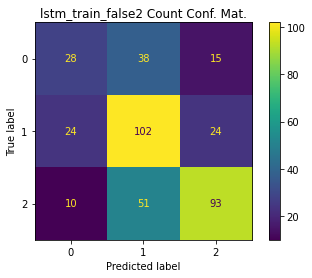

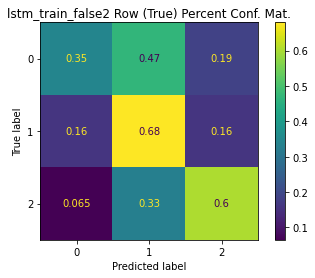

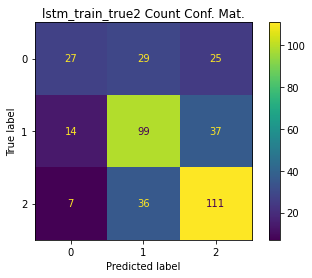

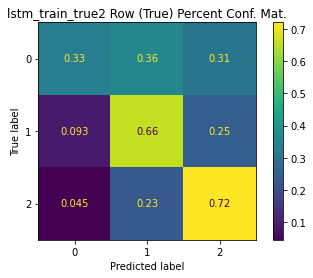

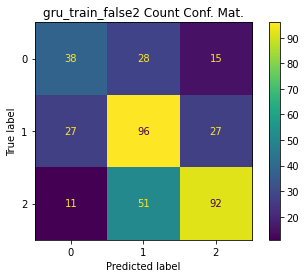

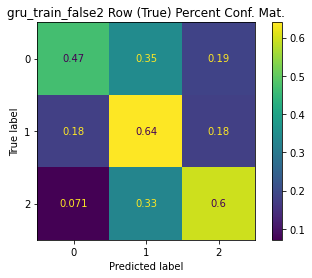

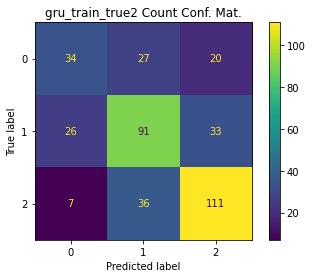

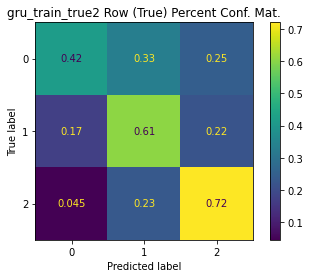

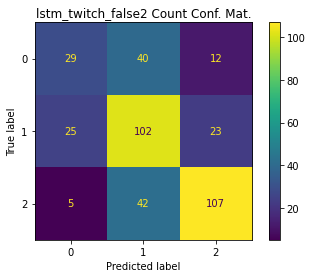

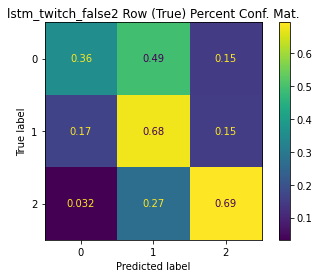

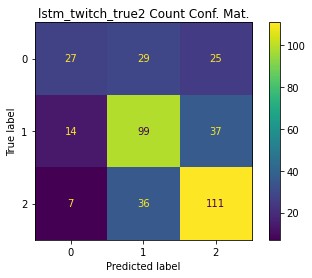

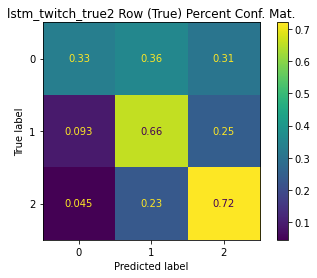

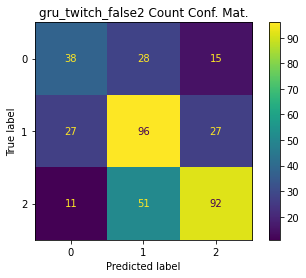

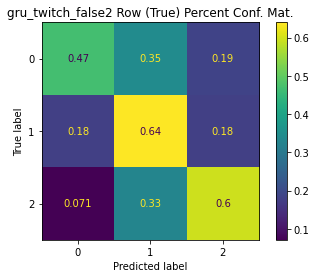

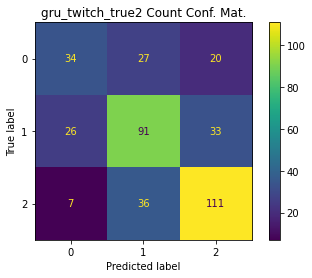

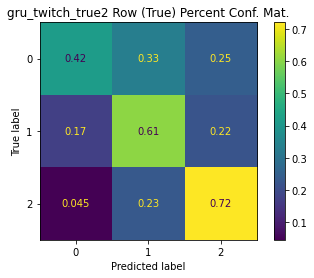

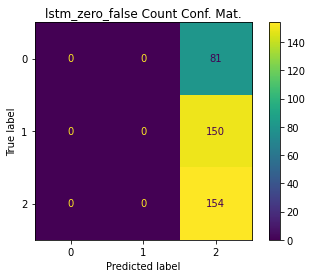

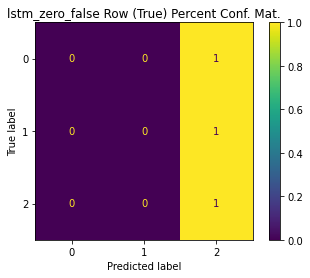

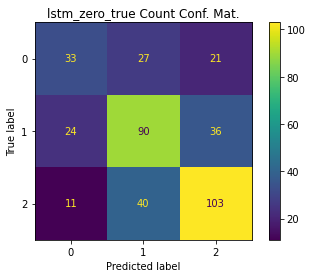

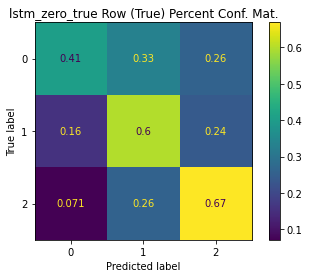

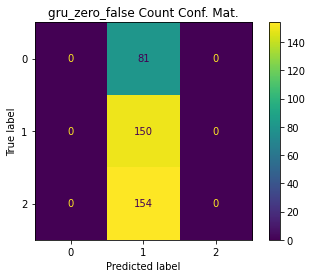

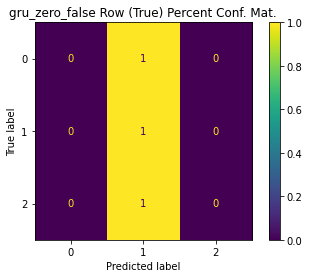

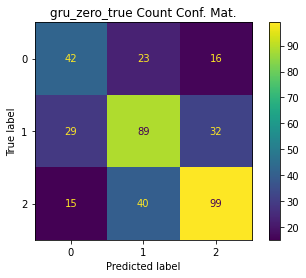

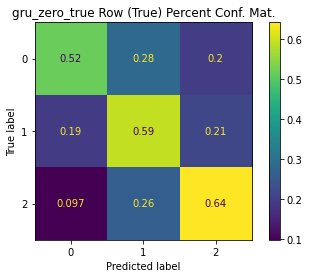

In [ ]:
output_prediction_results(pred_list = PRED_LIST, 
                          name_list = NAME_LIST, 
                          test_vec = y_test_vec)

# GRU with allowing training on the Twitch embeddings performed the best! Second best is LSTM with DISallowing training on the Twitch embeddings

# Multimodal

### Set up data

In [ ]:
COLUMNS

['channel', 'mod', 'subscriber']

In [ ]:
list(set(X["channel"]))

['forsen', 'riotgames', 'xqcow', 'moonmoon_ow', 'sodapoppin']

In [ ]:
x_two_train_channel = train_metadata["channel"].map({"forsen": 0, 
                                                 "riotgames": 1,
                                                 "xqcow": 2,
                                                 "moonmoon_ow": 3,
                                                 "sodapoppin":4
                                                 }).to_numpy().reshape(len(x_train),1)

x_two_train_mod = train_metadata['mod'].map({True: 1, 
                                             False: 0}).to_numpy().reshape(len(x_train),1)


x_two_train_sub = train_metadata['subscriber'].map({True: 1, 
                                                    False: 0}).to_numpy().reshape(len(x_train),1)


x_two_train = np.concatenate((x_two_train_channel, 
                              x_two_train_mod, 
                              x_two_train_sub), axis=1)

x_two_val_channel = valid_metadata["channel"].map({"forsen": 0, 
                                                 "riotgames": 1,
                                                 "xqcow": 2,
                                                 "moonmoon_ow": 3,
                                                 "sodapoppin":4
                                                 }).to_numpy().reshape(len(x_valid),1)
x_two_val_mod = valid_metadata['mod'].map({True: 1, 
                                           False: 0}).to_numpy().reshape(len(x_valid),1)
x_two_val_sub = valid_metadata['subscriber'].map({True: 1, 
                                                  False: 0}).to_numpy().reshape(len(x_valid),1)
x_two_val = np.concatenate((x_two_val_channel, 
                            x_two_val_mod, 
                            x_two_val_sub), axis=1)

x_two_test_channel = test_metadata["channel"].map({"forsen": 0, 
                                                 "riotgames": 1,
                                                 "xqcow": 2,
                                                 "moonmoon_ow": 3,
                                                 "sodapoppin":4
                                                 }).to_numpy().reshape(len(x_test),1)
x_two_test_mod = test_metadata['mod'].map({True: 1, False: 0}).to_numpy().reshape(len(x_test),1)
x_two_test_sub = test_metadata['subscriber'].map({True: 1, False: 0}).to_numpy().reshape(len(x_test),1)
x_two_test = np.concatenate((x_two_test_channel, 
                             x_two_test_mod, 
                             x_two_test_sub), axis=1)

In [ ]:
x_train[0:5]

,date,channel,game,user,mod,subscriber,message
906,2018-05-01T18:57:11.270Z,forsen,Fallout: New Vegas,67722,False,True,4house
1175,2018-05-21T23:09:00.511Z,sodapoppin,IRL,340845,False,False,say it trihard
359,2018-05-27T19:30:18.262Z,forsen,Dark Souls,676017,False,False,omegalul
1283,2018-05-13T03:29:19.964Z,moonmoon_ow,The Cat Lady,240892,False,True,wrong
1775,2018-05-11T16:30:22.923Z,forsen,IRL,71132,False,False,pepepains


In [ ]:
x_two_train[0:5]

array([[0, 0, 1],
       [4, 0, 0],
       [0, 0, 0],
       [3, 0, 1],
       [0, 0, 0]])

### Params

### Simple example

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
EARLY_STOP = EarlyStopping(monitor = "val_acc", mode = "max", 
                           patience = int(math.ceil(0.25 * EPOCHS) + 1), 
                           verbose = 1)

In [ ]:
TRAINABLE = True
EMBEDDING = embedding_matrix
CKPT = set_up_checkpoint("multi_modal_checkpoint_05_05_2022_jay")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable = TRAINABLE)
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x1 = layers.LSTM(NODES)(embedded_sequences)
x1 = layers.Dense(8, activation='relu')(x1)

metadata_input = Input(shape=x_two_train[0].shape)
x2 = layers.Dense(3, activation='relu')(metadata_input)

# Merge -> output
out = layers.Concatenate()([x1, x2])
out = layers.Dense(32, activation='relu')(out)
out = layers.Dense(len(classes), activation='softmax')(out)

multi_model = Model(inputs=[int_sequences_input, metadata_input], outputs=out)
multi_model.compile(optimizer=OPTIMIZER, loss=OBJECTIVE_FUNC, metrics=METRICS)
multi_model.summary()
multi_model.fit([x_train_message_vec, x_two_train], y_train_vec, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                validation_data=([x_valid_message_vec, x_two_val], y_valid_vec),
                callbacks = [EARLY_STOP, CKPT])

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_54 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, None, 200)    417600      ['input_54[0][0]']               
                                                                                                  
 lstm_47 (LSTM)                 (None, 128)          168448      ['embedding_19[0][0]']           
                                                                                                  
 input_55 (InputLayer)          [(None, 3)]          0           []                               
                                                                                           

pred_twitch_multi results:

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        81
           1      0.424     0.167     0.239       150
           2      0.402     0.851     0.546       154

    accuracy                          0.405       385
   macro avg      0.275     0.339     0.262       385
weighted avg      0.326     0.405     0.312       385


Confusion Matrix:
[[  0  11  70]
 [  0  25 125]
 [  0  23 131]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


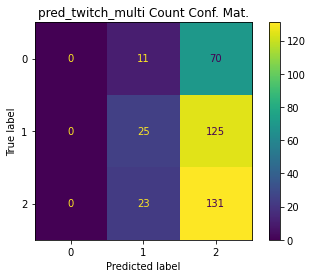

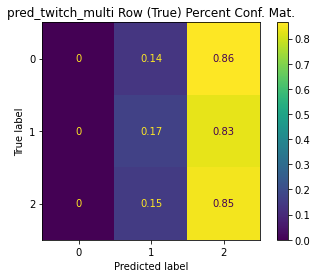

In [ ]:
y_hat_twitch_multi = multi_model.predict([x_test_message_vec, x_two_test])
pred_twitch_multi = output_prediction(y_hat_twitch_multi)
PRED_LIST = [pred_twitch_multi]
output_prediction_results(pred_list = PRED_LIST, 
                          name_list = NAME_LIST, 
                          test_vec = y_test_vec)

### Multimodal, Bidirectional LSTM

In [202]:
TRAINABLE = True
EMBEDDING = twitch_embedding_matrix
CKPT = set_up_checkpoint("multi_modal_checkpoint_05_05_2022_jay")
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(EMBEDDING), 
                            trainable = TRAINABLE)
# The question network
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x1 = layers.Bidirectional(layers.LSTM(NODES))(embedded_sequences)
x1 = layers.Dense(8, activation='relu')(x1)

metadata_input = Input(shape=x_two_train[0].shape)
x2 = layers.Dense(3, activation='relu')(metadata_input)

# Merge -> output
out = layers.Concatenate()([x1, x2])
out = layers.Dense(32, activation='relu')(out)
out = layers.Dense(len(classes), activation='softmax')(out)

multi_model = Model(inputs=[int_sequences_input, metadata_input], outputs=out)
multi_model.compile(optimizer=OPTIMIZER, loss=OBJECTIVE_FUNC, metrics=METRICS)
multi_model.summary()
multi_model.fit([x_train_message_vec, x_two_train], y_train_vec, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                validation_data=([x_valid_message_vec, x_two_val], y_valid_vec),
                callbacks = [EARLY_STOP, CKPT])

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_80 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_32 (Embedding)       (None, None, 200)    417600      ['input_80[0][0]']               
                                                                                                  
 bidirectional_67 (Bidirectiona  (None, 256)         336896      ['embedding_32[0][0]']           
 l)                                                                                               
                                                                                                  
 input_81 (InputLayer)          [(None, 3)]          0           []                        

pred_twitch_multi results:

              precision    recall  f1-score   support

           0      0.487     0.481     0.484        81
           1      0.593     0.593     0.593       150
           2      0.723     0.727     0.725       154

    accuracy                          0.623       385
   macro avg      0.601     0.601     0.601       385
weighted avg      0.623     0.623     0.623       385


Confusion Matrix:
[[ 39  28  14]
 [ 32  89  29]
 [  9  33 112]]


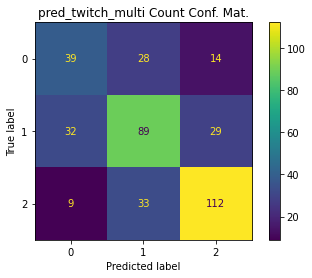

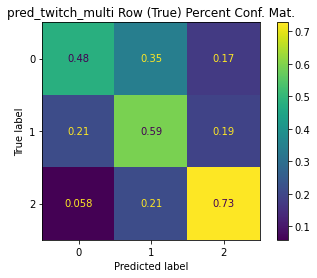

In [203]:
y_hat_twitch_multi = multi_model.predict([x_test_message_vec, x_two_test])
pred_twitch_multi = output_prediction(y_hat_twitch_multi)
PRED_LIST = [pred_twitch_multi]
NAME_LIST = ["pred_twitch_multi"]
output_prediction_results(pred_list = PRED_LIST, 
                          name_list = NAME_LIST, 
                          test_vec = y_test_vec)

### 2-layer bidirectional

In [198]:
NODES/8

16.0

In [ ]:
x_two_train[0].shape

(3,)

In [204]:
# The question network
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x1 = layers.Bidirectional(layers.LSTM(NODES, return_sequences=True))(embedded_sequences)
x1 = layers.Bidirectional(layers.LSTM(NODES))(x1)
x1 = layers.Dense(int(math.floor(NODES/8)), activation='relu')(x1)
x1 = layers.normalization.batch_normalization.BatchNormalization()(x1)

metadata_input = Input(shape=x_two_train[0].shape)
x2 = layers.Dense(3, activation='relu')(metadata_input)
x2 = layers.Dropout(.5)(x2)
x2 = layers.Dense(3, activation='relu')(x2)
x2 = layers.normalization.batch_normalization.BatchNormalization()(x2)

# Merge -> output
out = layers.Concatenate()([x1, x2])
out = layers.Dense(16, activation='relu')(out)
out = layers.Dense(len(classes), activation='softmax')(out)

multi_model = Model(inputs=[int_sequences_input, metadata_input], outputs=out)
multi_model.compile(optimizer=OPTIMIZER, loss=OBJECTIVE_FUNC, metrics=METRICS)

In [205]:
multi_model.summary()

Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_82 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_32 (Embedding)       (None, None, 200)    417600      ['input_82[0][0]']               
                                                                                                  
 input_83 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 bidirectional_68 (Bidirectiona  (None, None, 256)   336896      ['embedding_32[1][0]']           
 l)                                                                                        

In [206]:
CKPT = set_up_checkpoint("multi_modal_checkpoint_05_05_2022_3")

In [207]:
multi_model.fit([x_train_message_vec, x_two_train], y_train_vec, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                validation_data=([x_valid_message_vec, x_two_val], y_valid_vec),
                callbacks = [EARLY_STOP, CKPT])

Epoch 1/32
84/84 [==============================] - ETA: 0s - loss: 0.8412 - acc: 0.6369
Epoch 1: val_acc improved from -inf to 0.60622, saving model to multi_modal_checkpoint_05_05_2022_3
84/84 [==============================] - 8s 37ms/step - loss: 0.8412 - acc: 0.6369 - val_loss: 0.9111 - val_acc: 0.6062
Epoch 2/32
81/84 [===========================>..] - ETA: 0s - loss: 0.5119 - acc: 0.8164
Epoch 2: val_acc improved from 0.60622 to 0.62176, saving model to multi_modal_checkpoint_05_05_2022_3
84/84 [==============================] - 2s 21ms/step - loss: 0.5141 - acc: 0.8162 - val_loss: 0.8511 - val_acc: 0.6218
Epoch 3/32
84/84 [==============================] - ETA: 0s - loss: 0.3617 - acc: 0.8780
Epoch 3: val_acc improved from 0.62176 to 0.62694, saving model to multi_modal_checkpoint_05_05_2022_3
84/84 [==============================] - 2s 19ms/step - loss: 0.3617 - acc: 0.8780 - val_loss: 0.8854 - val_acc: 0.6269
Epoch 4/32
84/84 [==============================] - ETA: 0s - loss:

pred_twitch_multi results:

              precision    recall  f1-score   support

           0      0.474     0.444     0.459        81
           1      0.583     0.653     0.616       150
           2      0.738     0.675     0.705       154

    accuracy                          0.618       385
   macro avg      0.598     0.591     0.593       385
weighted avg      0.622     0.618     0.619       385


Confusion Matrix:
[[ 36  31  14]
 [ 29  98  23]
 [ 11  39 104]]


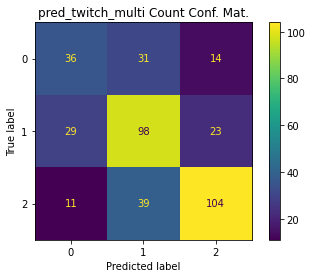

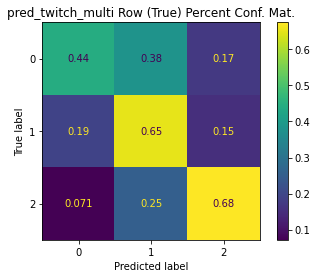

In [199]:
y_hat_twitch_multi = multi_model.predict([x_test_message_vec, x_two_test])
pred_twitch_multi = output_prediction(y_hat_twitch_multi)
PRED_LIST = [pred_twitch_multi]
NAME_LIST = ["pred_twitch_multi"]
output_prediction_results(pred_list = PRED_LIST, 
                          name_list = NAME_LIST, 
                          test_vec = y_test_vec)

# Multimodal GRU

### Simple GRU

In [ ]:
# The question network
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x1 = layers.GRU(NODES)(embedded_sequences)
x1 = layers.Dense(8, activation='relu')(x1)

metadata_input = Input(shape=x_two_train[0].shape)
x2 = layers.Dense(3, activation='relu')(metadata_input)

# Merge -> output
out = layers.Concatenate()([x1, x2])
out = layers.Dense(32, activation='relu')(out)
out = layers.Dense(len(classes), activation='softmax')(out)

multi_model = Model(inputs=[int_sequences_input, metadata_input], outputs=out)
multi_model.compile(optimizer = OPTIMIZER, loss=OBJECTIVE_FUNC, metrics=METRICS)

In [ ]:
multi_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, None, 200)    417600      ['input_28[0][0]']               
                                                                                                  
 gru_13 (GRU)                   (None, 128)          126720      ['embedding_16[4][0]']           
                                                                                                  
 input_29 (InputLayer)          [(None, 3)]          0           []                               
                                                                                           

In [ ]:
multi_model.fit([x_train_message_vec, x_two_train], y_train_vec, 
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS, 
                validation_data=([x_valid_message_vec, x_two_val], y_valid_vec),
                callbacks = [EARLY_STOP, CKPT])

Epoch 1/32
82/84 [============================>.] - ETA: 0s - loss: 1.0926 - acc: 0.3720
Epoch 1: val_acc did not improve from 0.67358
84/84 [==============================] - 3s 15ms/step - loss: 1.0908 - acc: 0.3728 - val_loss: 1.0688 - val_acc: 0.3679
Epoch 2/32
83/84 [============================>.] - ETA: 0s - loss: 1.0643 - acc: 0.3765
Epoch 2: val_acc did not improve from 0.67358
84/84 [==============================] - 1s 8ms/step - loss: 1.0656 - acc: 0.3743 - val_loss: 1.0626 - val_acc: 0.4093
Epoch 3/32
79/84 [===========================>..] - ETA: 0s - loss: 1.0620 - acc: 0.3972
Epoch 3: val_acc did not improve from 0.67358
84/84 [==============================] - 1s 8ms/step - loss: 1.0605 - acc: 0.4018 - val_loss: 1.0703 - val_acc: 0.4041
Epoch 4/32
83/84 [============================>.] - ETA: 0s - loss: 1.0604 - acc: 0.3946
Epoch 4: val_acc did not improve from 0.67358
84/84 [==============================] - 1s 8ms/step - loss: 1.0614 - acc: 0.3929 - val_loss: 1.0603 -

pred_twitch_multi results:

              precision    recall  f1-score   support

           0      0.580     0.358     0.443        81
           1      0.571     0.773     0.657       150
           2      0.773     0.662     0.713       154

    accuracy                          0.642       385
   macro avg      0.641     0.598     0.604       385
weighted avg      0.654     0.642     0.635       385


Confusion Matrix:
[[ 29  40  12]
 [ 16 116  18]
 [  5  47 102]]


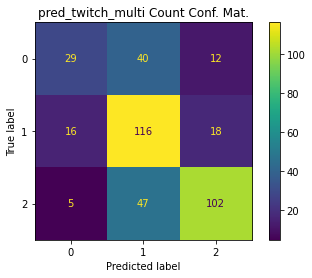

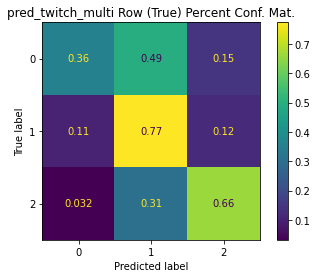

In [ ]:
y_hat_twitch_multi = multi_model.predict([x_test_message_vec, x_two_test])
pred_twitch_multi = output_prediction(y_hat_twitch_multi)
PRED_LIST = [pred_twitch_multi]
NAME_LIST = ["pred_twitch_multi"]
output_prediction_results(pred_list = PRED_LIST, 
                          name_list = NAME_LIST, 
                          test_vec = y_test_vec)

# Multimodal zero embeddings

In [ ]:
TRAINABLE = True
embedding_layer = Embedding(NUM_TOKENS,  EMBEDDING_DIMENSION, 
                            embeddings_initializer= Constant(zero_matrix), 
                            trainable = TRAINABLE)

In [ ]:
# The question network
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x1 = layers.LSTM(32)(embedded_sequences)
x1 = layers.Dense(16, activation='relu')(x1)

metadata_input = Input(shape=x_two_train[0].shape)
x2 = layers.Dense(2, activation='relu')(metadata_input)

# Merge -> output
out = layers.Concatenate()([x1, x2])
out = layers.Dense(24, activation='tanh')(out)
out = layers.Dense(len(classes), activation='softmax')(out)

multi_model = Model(inputs=[int_sequences_input, metadata_input], outputs=out)
multi_model.compile(Adam(lr=5e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
multi_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_49 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, None, 200)    417600      ['input_49[0][0]']               
                                                                                                  
 lstm_23 (LSTM)                 (None, 32)           29824       ['embedding_16[0][0]']           
                                                                                                  
 input_50 (InputLayer)          [(None, 2)]          0           []                               
                                                                                           

In [ ]:
multi_model.fit([x_train_message_vec, x_two_train], y_train_vec, 
                batch_size=batch_len, 
                epochs=num_epochs + 50, 
                validation_data=([x_valid_message_vec, x_two_val], y_valid_vec))
                # callbacks = [EARLY_STOP])

Epoch 1/100
84/84 [==============================] - 2s 11ms/step - loss: 1.0793 - accuracy: 0.3869 - val_loss: 1.0749 - val_accuracy: 0.4301
Epoch 2/100
84/84 [==============================] - 1s 6ms/step - loss: 1.0679 - accuracy: 0.4010 - val_loss: 1.0695 - val_accuracy: 0.4301
Epoch 3/100
84/84 [==============================] - 1s 7ms/step - loss: 1.0649 - accuracy: 0.4122 - val_loss: 1.0677 - val_accuracy: 0.4301
Epoch 4/100
84/84 [==============================] - 1s 6ms/step - loss: 1.0633 - accuracy: 0.4159 - val_loss: 1.0661 - val_accuracy: 0.4301
Epoch 5/100
84/84 [==============================] - 1s 6ms/step - loss: 1.0627 - accuracy: 0.4152 - val_loss: 1.0650 - val_accuracy: 0.4301
Epoch 6/100
84/84 [==============================] - 1s 6ms/step - loss: 1.0621 - accuracy: 0.4167 - val_loss: 1.0640 - val_accuracy: 0.4301
Epoch 7/100
84/84 [==============================] - 1s 7ms/step - loss: 1.0617 - accuracy: 0.4159 - val_loss: 1.0633 - val_accuracy: 0.4301
Epoch 8/100


KeyboardInterrupt: ignored